# Hydrologic conditioning: making sure water flows downhill

In short hydrologic conditioning is the process of removing image artifacts and conditioning digitally flat areas within a Digital Elevation Model (DEM) to ensure that a catchment drains from upstream to downstream end. There are many methods for hydrologic conditioning, the "D-Any" package contains two primary methods based on the priority flood method:

   - `Improved epsilon fill`: Hydrologic conditioning method that applies a slight "epsilon" fill in digitally flat areas to ensure water drains across these areas
   - `Complete fill`: Standard priority flood method where epsilon = 0

This notebook will generate a model domain and use hydrologic conditioning methods on a resampled DEM.

In [1]:
import dany
import flopy 
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt

from dataretrieval import nldi, nwis
from pyproj import Transformer

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# define our CRS systems
epsg_utm = 26911  # NAD83 UTM zone 11 N
epsg_wgs84 = 4326  # Decimal lat, lon for dataretrieval queries

### Get started by generating a mesh (model grid) to work with

For more information about mesh generation see these notebooks: 
   - [Complex_meshes_from_existing_boundary](Complex_meshes_from_existing_boundary.ipynb)
   - [Complex_meshes_from_existing_raster](Complex_meshes_from_existing_raster.ipynb)

Load our raster to get the model boundaries

In [2]:
dem_file = pl.Path("../data/dem.img")
rstr = flopy.utils.Raster.load(dem_file)
xmin, xmax, ymin, ymax = rstr.bounds

Get USGS stream gage stations and the NHD-Plus watershed boundary

In [3]:
# transform our raster boundaries
transformer = Transformer.from_crs(epsg_utm, epsg_wgs84, always_xy=True)
xmin, ymin = transformer.transform(xmin, ymin)
xmax, ymax = transformer.transform(xmax, ymax)
wgs_bounds = [xmin, ymin, xmax, ymax]

In [4]:
info, _ = nwis.get_info(bBox=[f"{i :.2f}" for i in wgs_bounds])
info.to_crs(epsg=epsg_utm, inplace=True)
info = info[info.site_tp_cd == "ST"]
info

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
1,USGS,10343000,INDEPENDENCE C NR TRUCKEE CA,ST,392724.0,1201710.0,39.456572,-120.287148,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (217168.338 4372603.864)
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.0,39.431572,-120.237979,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (221299.997 4369675.311)
3,USGS,392501120182800,SAGEHEN CR NR CARPENTER RIDGE CA,ST,392501.0,1201828.0,39.416849,-120.308814,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (215141.782 4368262.355)
5,USGS,392558120152000,PRE-CAMPGROUND TRIB NR HOBART MILLS CA,ST,392558.0,1201520.0,39.432683,-120.256591,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (219702.187 4369856.371)
6,USGS,392558120152100,SAGEHEN CR AB CAMPGROUND NR HOBART MILLS CA,ST,392558.0,1201521.0,39.432683,-120.256868,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (219678.280 4369857.235)
7,USGS,392602120164500,SAGEHEN HILLS TRIB NR HOBART MILLS CA,ST,392602.0,1201645.0,39.433794,-120.280203,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (217673.955 4370053.418)
8,USGS,392604120164900,SAGEHEN CR BELOW LOGGED AREA NR HOBART MILLS CA,ST,392604.0,1201649.0,39.434350,-120.281314,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (217580.549 4370118.578)


In [5]:
# get upsteam basin for site-no 10343500
basindf = nldi.get_basin(feature_source="nwissite", feature_id=f"USGS-{info.site_no.values[1]}")
basindf.to_crs(epsg=epsg_utm, inplace=True)

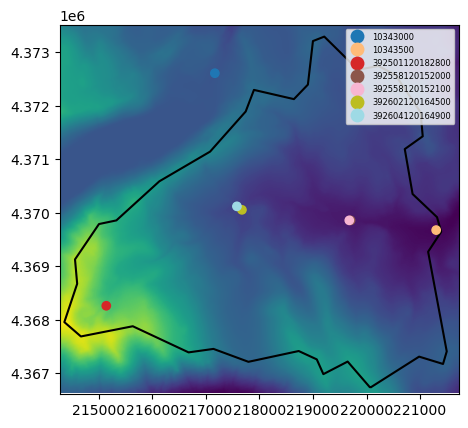

In [6]:
# plot it up to view the stream gage stations within the basin
fig, ax = plt.subplots()
rstr.plot(ax=ax)
basindf.plot(ax=ax, facecolor="None", edgecolor="k", lw=1.5)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6});

#### Generating the mesh from the basin boundary

For this example, we'll generate a complex mesh using the existing NHD-Plus boundary

In [7]:
from flopy.utils.triangle import Triangle
ws = pl.Path("./sh_tri")
ws.mkdir(exist_ok=True)

tri = Triangle(angle=30, model_ws=ws)
tri.add_polygon(basindf.geometry.values[0])
tri.add_region(basindf.centroid.values[0], 0, maximum_area=7000)
tri.build()

Create a voronoi mesh from the triangulation

In [8]:
from flopy.utils.voronoi import VoronoiGrid

vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
vorgrid = flopy.discretization.VertexGrid(nlay=1, **gridprops)

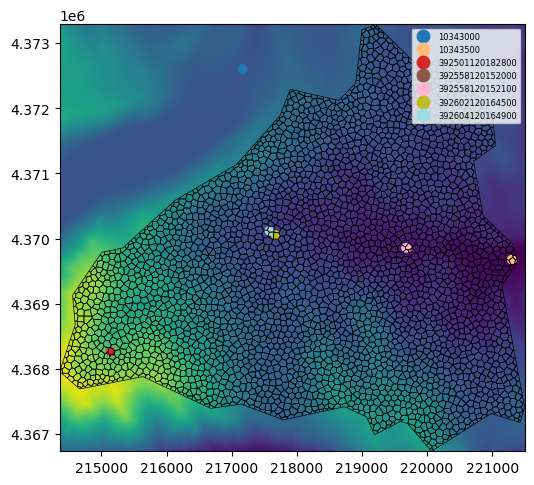

In [9]:
# plot the grid
fig, ax = plt.subplots(figsize=(6, 6))

rstr.plot(ax=ax)
pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pmv.plot_grid(color="k", lw=0.5)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6});

## Resampling the DEM and performing hydrologic conditioning

This section outlines the process of resampling a digital elevation map to the modelgrid and applying complete fill and epsilon fill priority flood methods on an unstructured (or structured) grid.

### Raster resampling
Rasters can be resampled using FloPy's `Raster` utility. The raster utility has a `reasmple_to_grid()` method for resampling raster data to the grid scale. The input parameters to `resample_to_grid()` include:
   - `modelgrid` : A flopy.discretization.Grid object. This can be a `StructuredGrid`, `VertexGrid`, or `UnstructuredGrid`
   - `band`: integer, raster band number
   - `method`: string, resampling method. Methods include 'min', 'max', 'median', 'mean', 'mode', 'nearest', 'linear', and 'cubic'. `'min'` is recommended in most cases for DEM resampling.
   - `extrapolate_edges`: boolean, extrapolate data to modelgrid edge cells that do not intersect with the raster. Defaults to False

In [10]:
# load raster
rstr = flopy.utils.Raster.load(dem_file)
dem = rstr.resample_to_grid(
    vorgrid,
    band=rstr.bands[0],
    method='min'
)
dem[dem == rstr.nodatavals[0]] = np.nan

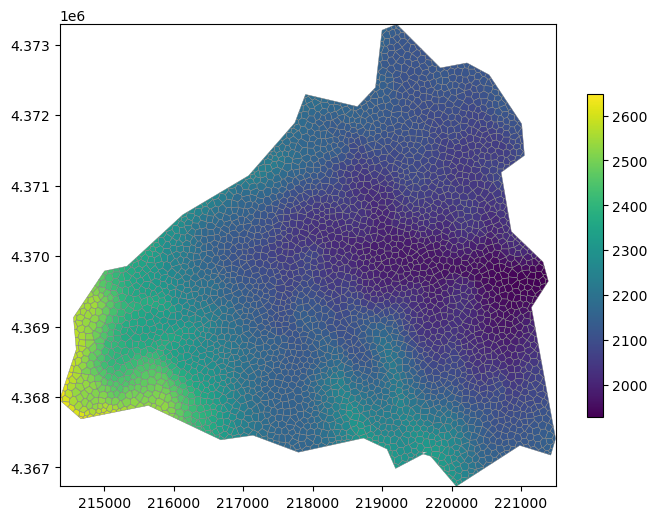

In [11]:
# plot the resampled raster
fig, ax = plt.subplots(figsize=(8, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pc = pmv.plot_array(dem)
pmv.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

### Filling "NaN" values in the resampled DEM

Occasionally resampling produces some local "NaN" values in the DEM array. This is usually due to no data values present in the raster itself. To fill these values, we can use the method `dany.fill_nan_values()`. `fill_nan_values()` finds the nearest neighbors to each nan cell and allows the user to chose one of 4 statistical methods to fill that cell. The method has three parameters:
   - `modelgrid`: flopy.discretization.Grid object; this method supports StructuredGrid, VertexGrid, and UnstructuredGrid objects from FloPy
   - `dem`: resampled digital elevation model array
   - `method`: filling method. `mean`, `median`, `min`, or `max` is supported. The statistic is based on the DEM values of the cells nearest neighbors. Default is `mean`.

In [12]:
filled_dem = dany.fill_nan_values(vorgrid, dem, method="mean")
print(np.where(np.isnan(filled_dem)))

(array([], dtype=int64),)


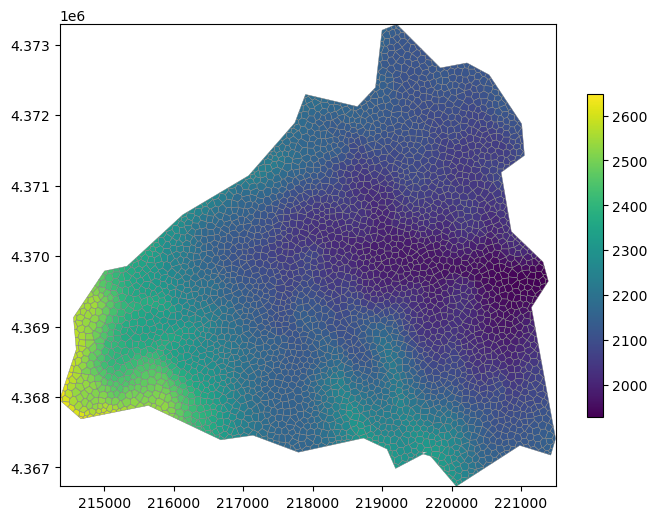

In [13]:
# plot the filled dem
fig, ax = plt.subplots(figsize=(8, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pc = pmv.plot_array(filled_dem)
pmv.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

### Filling sinks and digitally flat areas

D-Any has built in sink filling methods based on the improved epsilon priority flood method (Barnes et. al, 2014). The method here extends this algorithm to work with non-uniform grids, like the Voronoi mesh that is being worked with in this example. D-Any's method `fill_sinks` has a few input parameters:
   - `modelgrid`: flopy.discetization.Grid object
   - `dem`: np.array of digital elevations that has the size equivalent to the number of cells in the upper layer of the modelgrid
   - `eps`: float, epsilon fill value to remove digitally flat areas. If epsilon=0, this is the same as a "complete fill" method. Default value is 1e-06.
   - `stream_mask`: optional, numpy array of boolean values to deliniate existing stream line-work.  stream_mask only works with the priority flood fill method (`'priority'` or `'complete'`)
   - `method`: string, sink fill method. `"priority"` (default) runs the improved priority-flood algorithm described in Barnes et. al (2014) which is an efficient single pass epsilon filling method in this implementation. `"complete"` also runs the improved priority-flood algorithm, however does not use epsilon filling to correct digitally flat areas of the DEM. `"drain"` uses the direct implementation of Planchon and Darboux (2001) to perform epsilon filling. The `"drain"` method is iterative and therefore slower than the `"priority"` or `"complete"` method. 

#### Improved-Epsilon priority flood filling

The improved-epsilon priority flood method is the default sink filling method in "D-Any". This method fills with a single pass over the data and uses an epsilon offset to condition digitally flat areas of the resampled DEM. 

In [14]:
conditioned_dem = dany.fill_sinks(vorgrid, filled_dem, eps=2e-06)

In [15]:
diff = conditioned_dem - filled_dem
diff[diff == 0] = np.nan

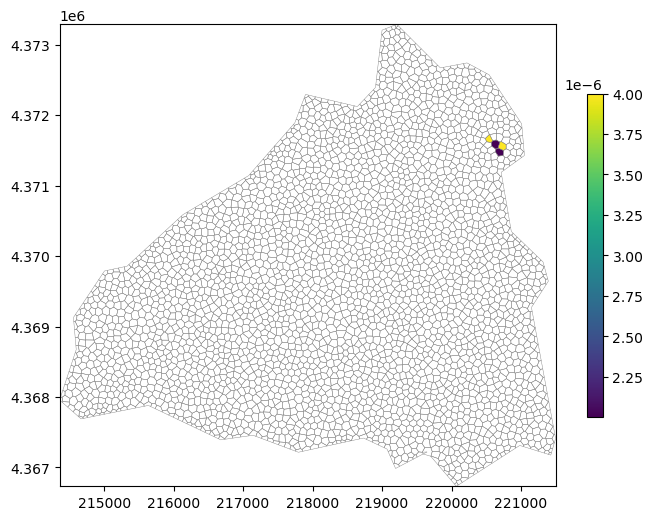

In [16]:
# plot the difference between the conditioned and filled dem
fig, ax = plt.subplots(figsize=(8, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pc = pmv.plot_array(diff)
pmv.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

There are a few cells that were hydrologically conditioned using the epsilon fill method. All other cells drain naturally

#### Complete Filling
The complete method is similar to epsilon filling, however it does not adjust digitally flat areas and can also create digitally flat areas in the case of mult-node sinks. Here we'll apply it to the dem data

In [17]:
complete_dem = dany.fill_sinks(vorgrid, filled_dem, method="complete") # we could also set eps=0 to accomplish complete fill
diff2 = complete_dem - filled_dem
diff2[diff2 == 0] = np.nan

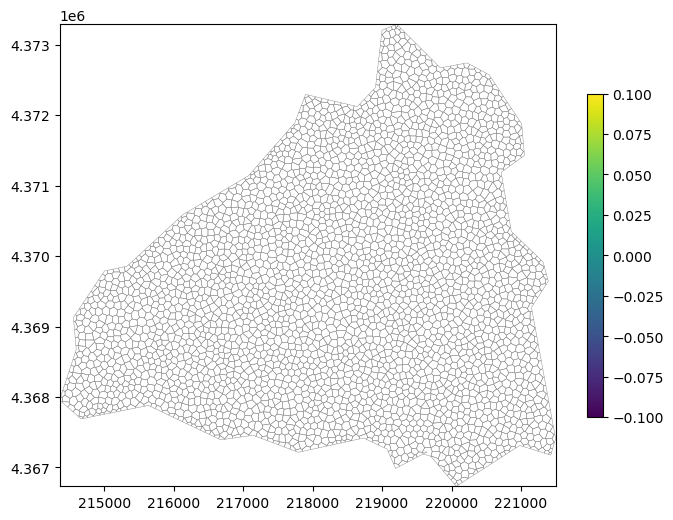

In [18]:
# plot the difference between the conditioned and filled dem
fig, ax = plt.subplots(figsize=(8, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pc = pmv.plot_array(diff2)
pmv.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

#### Flood and Drain filling
The flood and drain method is an epsilon filling algorithm. Results are generally similar to the default method; however, it is iterative and therefore slower than the default Priority Flood method. 

In [19]:
drain_dem = dany.fill_sinks(vorgrid, filled_dem, eps=2e-06, method="drain")
diff3 = drain_dem - filled_dem
diff3[diff3 == 0] = np.nan

Flood and Fill conditioning: iteration 1
Flood and Fill conditioning: iteration 2
Flood and Fill conditioning: iteration 3
Flood and Fill conditioning: iteration 4
Flood and Fill conditioning: iteration 5
Flood and Fill conditioning: iteration 6
Flood and Fill conditioning: iteration 7
Flood and Fill conditioning: iteration 8
Flood and Fill conditioning: iteration 9
Flood and Fill conditioning: iteration 10
Flood and Fill conditioning: iteration 11
Flood and Fill conditioning: iteration 12
Flood and Fill conditioning: iteration 13
Flood and Fill conditioning: iteration 14
Flood and Fill conditioning: iteration 15
Flood and Fill conditioning: iteration 16
Flood and Fill conditioning: iteration 17
Flood and Fill conditioning: iteration 18
Flood and Fill conditioning: iteration 19
Flood and Fill conditioning: iteration 20
Flood and Fill conditioning: iteration 21
Flood and Fill conditioning: iteration 22
Flood and Fill conditioning: iteration 23


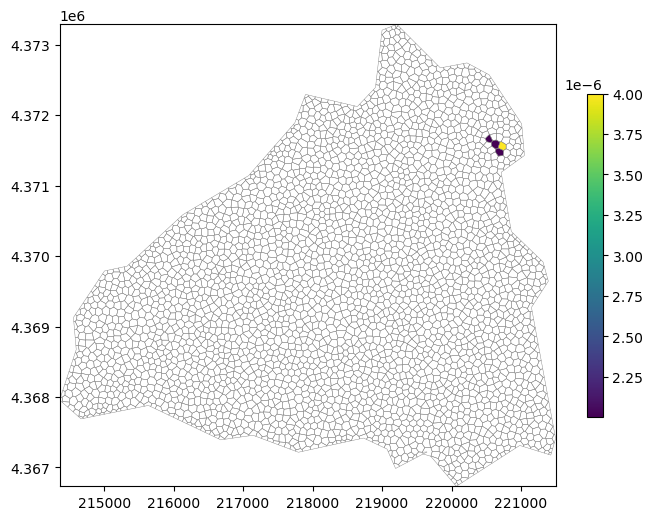

In [20]:
# plot the difference between the conditioned and filled dem
fig, ax = plt.subplots(figsize=(8, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pc = pmv.plot_array(diff3)
pmv.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

### Conditioning a DEM with an existing stream network

In some cases, such as study areas with large digitally flat expanses, an existing stream network can help condition the DEM to assure water drains from the upstream end of the basin to the downstream end. The `stream_mask` parameter can be used to aid in that conditioning. Below is an example of using the NHD-Plus stream network to aid in the hydrologic conditioning of the DEM. 

**Note:** Many basins do not need this processing, it is recommended to skip this and come back to it if stream delineation later is difficult for the basin.

This example uses `dataretrieval` to get flowlines from NHD-Plus and then creates a stream mask from those lines

In [21]:
nhddf = nldi.get_flowlines(
    navigation_mode="UT", 
    distance=999, 
    feature_source="nwissite", 
    feature_id=f"USGS-{info.site_no.values[1]}"
)
nhddf = nhddf.to_crs(epsg=epsg_utm)

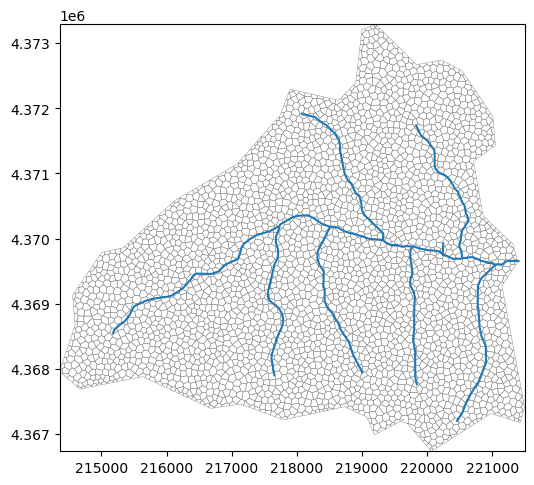

In [22]:
# plot it up, to make sure it overlays the grid
fig, ax = plt.subplots(figsize=(6, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pmv.plot_grid(lw=0.3)
nhddf.plot(ax=ax);

Create the stream mask using FloPy's `GridIntersect` class

In [23]:
ix = flopy.utils.GridIntersect(vorgrid, method="vertex")
result = []
for geom in nhddf.geometry.values:
    cellids = ix.intersect(geom)["cellids"]
    result.extend(list(cellids))

strm_mask = np.zeros((vorgrid.ncpl,), dtype=int)
strm_mask[result] = 1

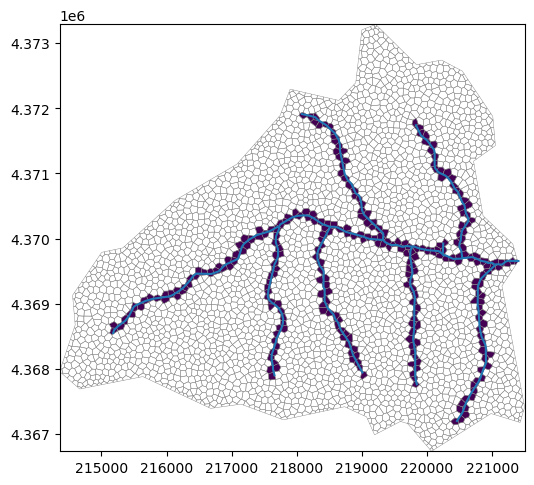

In [24]:
# plot the stream mask
fig, ax = plt.subplots(figsize=(6, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pmv.plot_array(strm_mask, masked_values=[0,])
pmv.plot_grid(lw=0.3)
nhddf.plot(ax=ax);

Do the hydrologic conditioning with a stream mask

In [25]:
strm_mask_dem = dany.fill_sinks(
    vorgrid,
    filled_dem,
    eps=2e-06,
    stream_mask=strm_mask
)
diff = strm_mask_dem - filled_dem

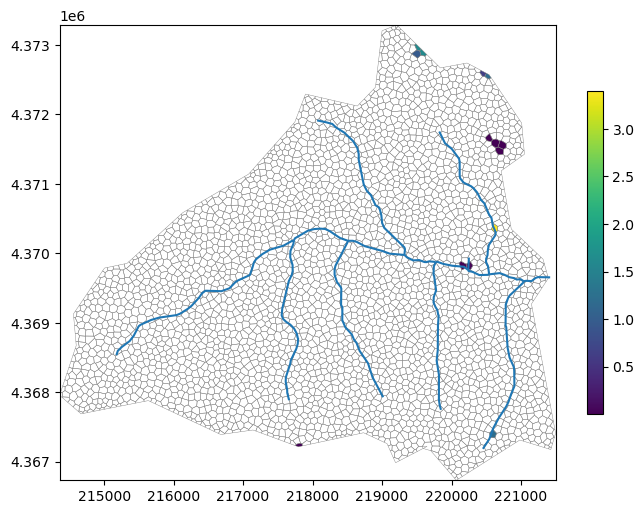

In [26]:
# plot up the difference after conditioning
fig, ax = plt.subplots(figsize=(8, 6))

pmv = flopy.plot.PlotMapView(modelgrid=vorgrid, ax=ax)
pc = pmv.plot_array(diff, masked_values=[0,])
pmv.plot_grid(lw=0.3)
nhddf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

### Next Steps
Once a DEM has been conditioned flow directions can be calculated and flow accumulation can be performed. See the other notebook examples for this process